All features are present.
Model for Adjusted net enrollment rate, primary Disparity:
  Mean Squared Error: 14.268920404533274
  R-squared: -0.749426855435251



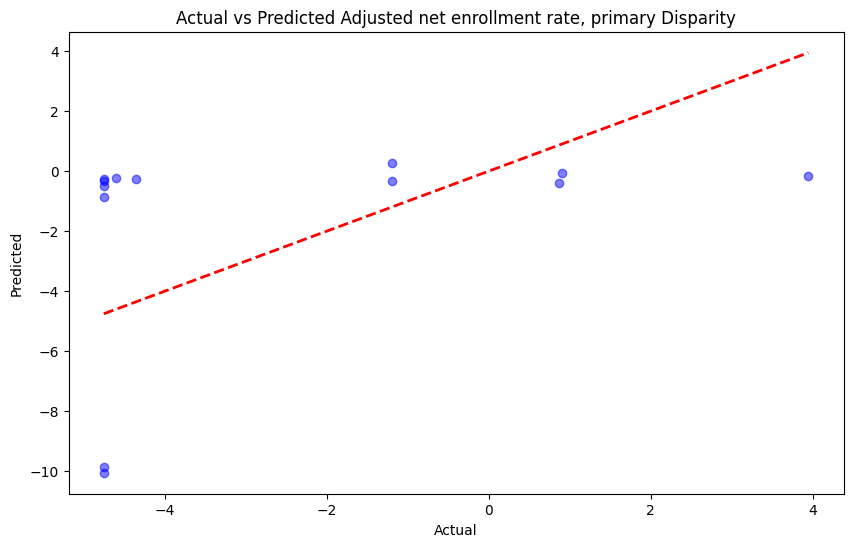

Model for Literacy rate, adult Disparity:
  Mean Squared Error: 116.0709202838546
  R-squared: -101.38519519302673



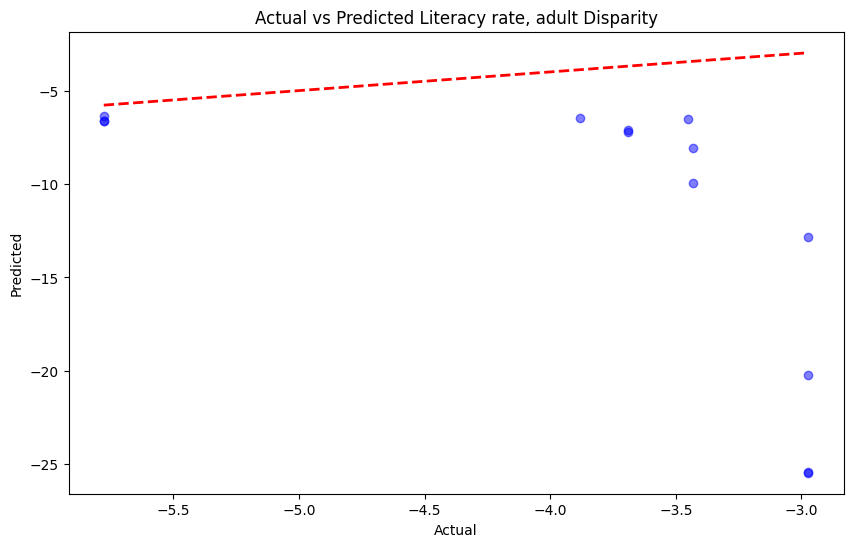

Model for Literacy rate, youth Disparity:
  Mean Squared Error: 13.278579143204135
  R-squared: -479.88420692670445



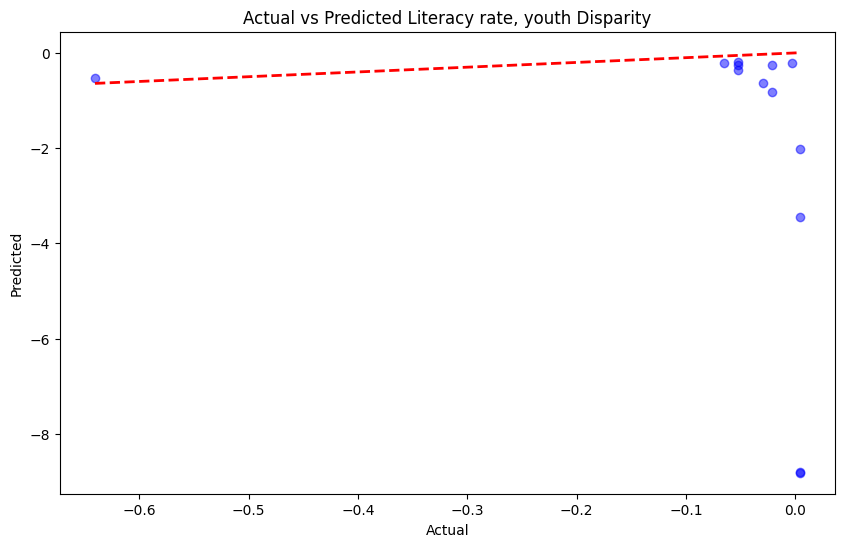

Model for Primary completion rate Disparity:
  Mean Squared Error: 16.23673229844163
  R-squared: -0.8438905190123827



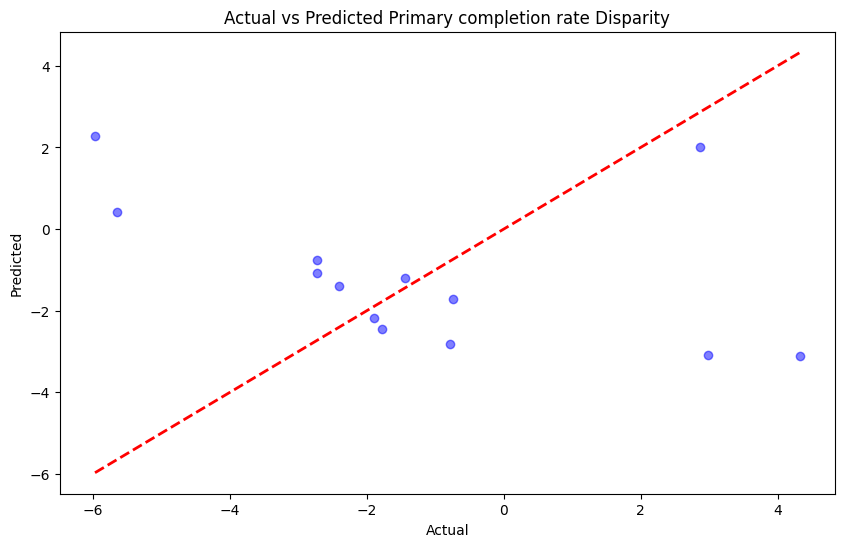

Model for Repeaters, primary Disparity:
  Mean Squared Error: 482.23137011923416
  R-squared: -0.9779048564270456



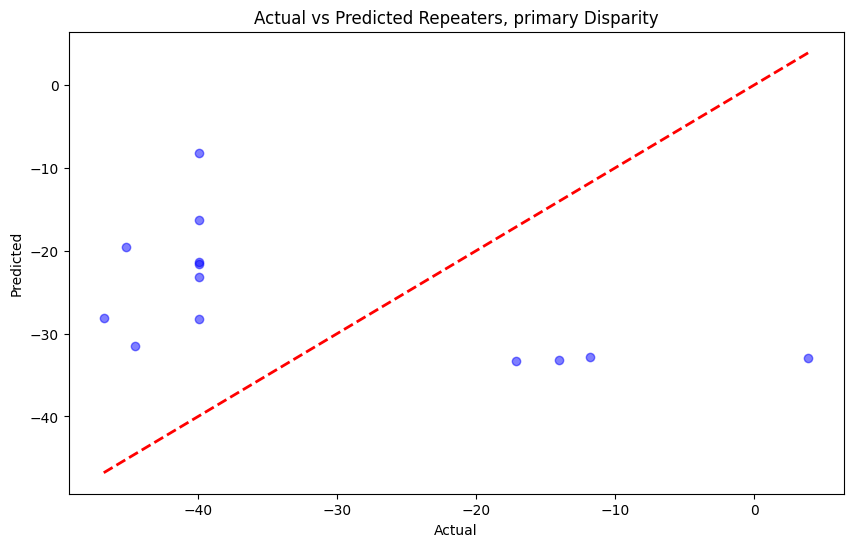

Model for School enrollment, preprimary Disparity:
  Mean Squared Error: 199.60884229521096
  R-squared: -3.5373995773854583



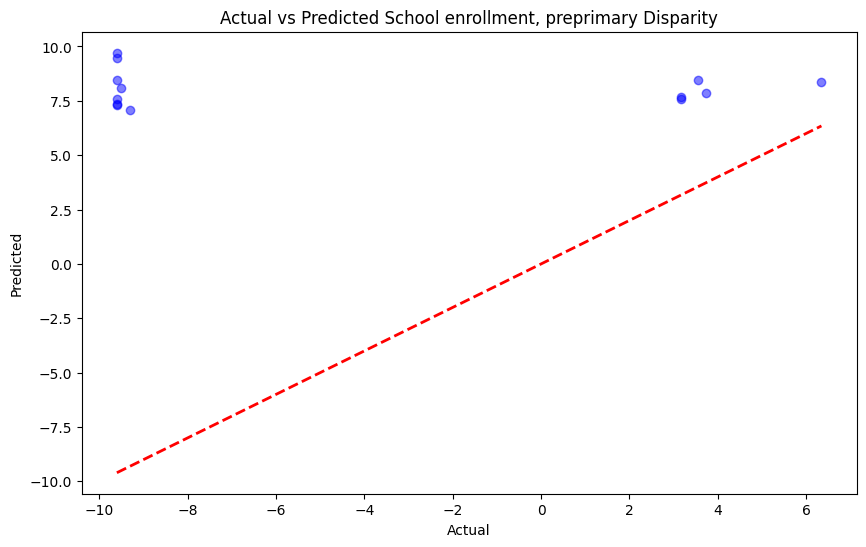

Model for School enrollment, primary (gross) Disparity:
  Mean Squared Error: 4.719666487195261
  R-squared: -0.20771745540408926



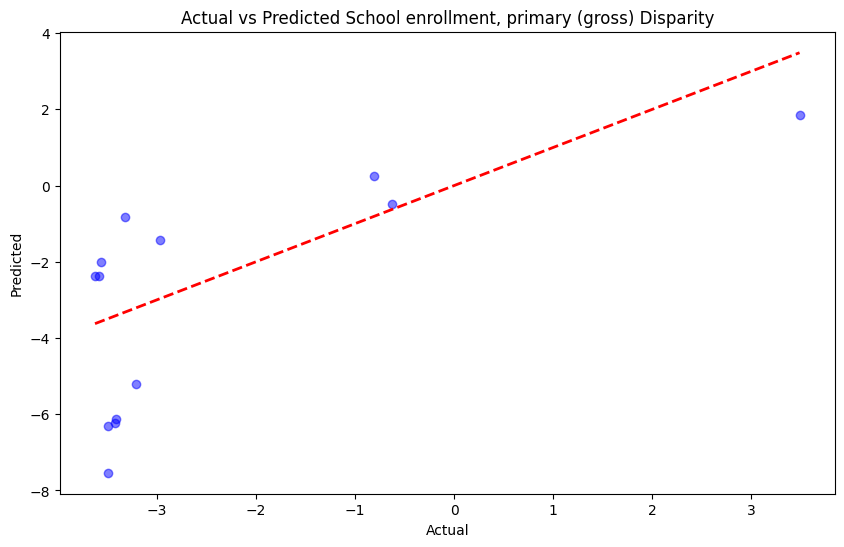

Model for School enrollment, primary (net) Disparity:
  Mean Squared Error: 12.133710201015939
  R-squared: -0.33263869887253605



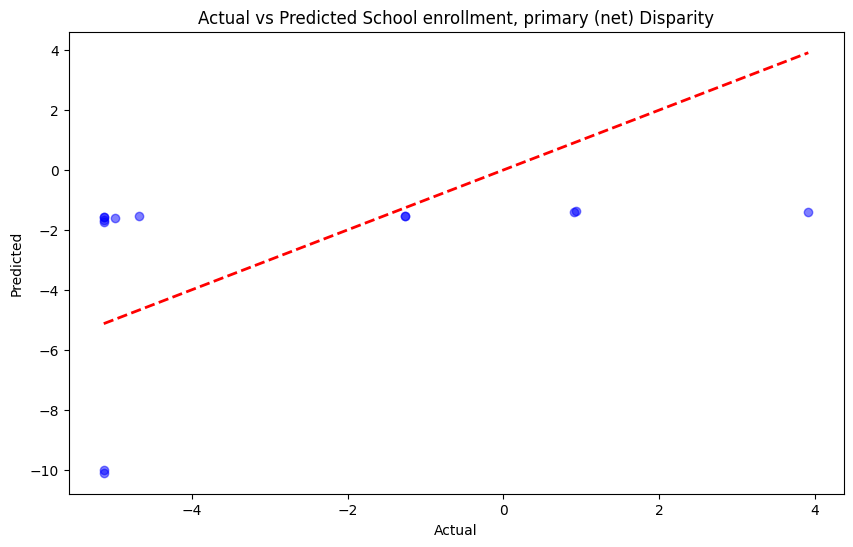

Model for School enrollment, secondary (gross) Disparity:
  Mean Squared Error: 168.61556273443273
  R-squared: -73.89251245240759



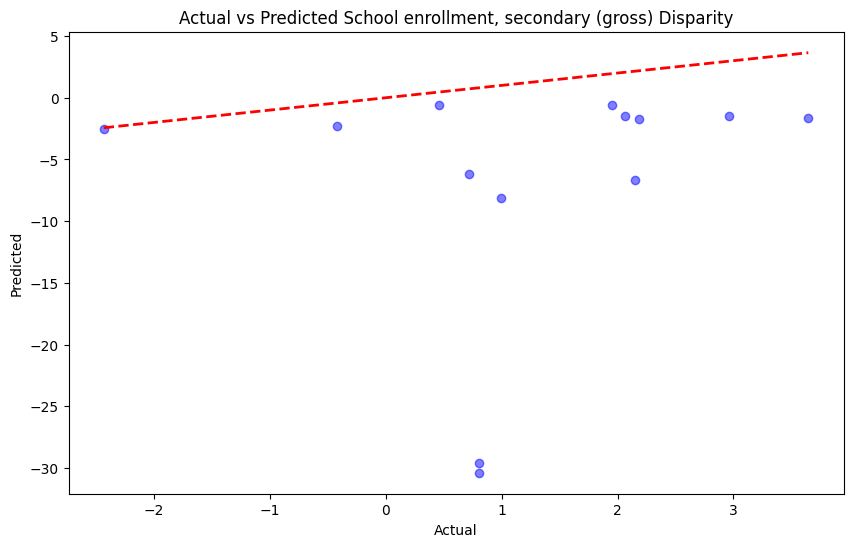

Model for School enrollment, secondary (net) Disparity:
  Mean Squared Error: 207.2435879150069
  R-squared: -71.26277540605378



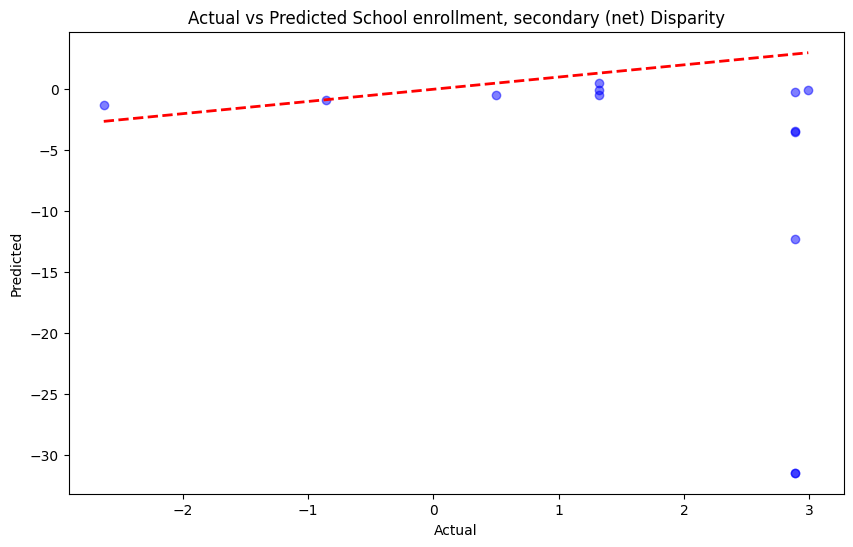

Model for School enrollment, tertiary Disparity:
  Mean Squared Error: 1932.7767259261893
  R-squared: -32.44897621940515



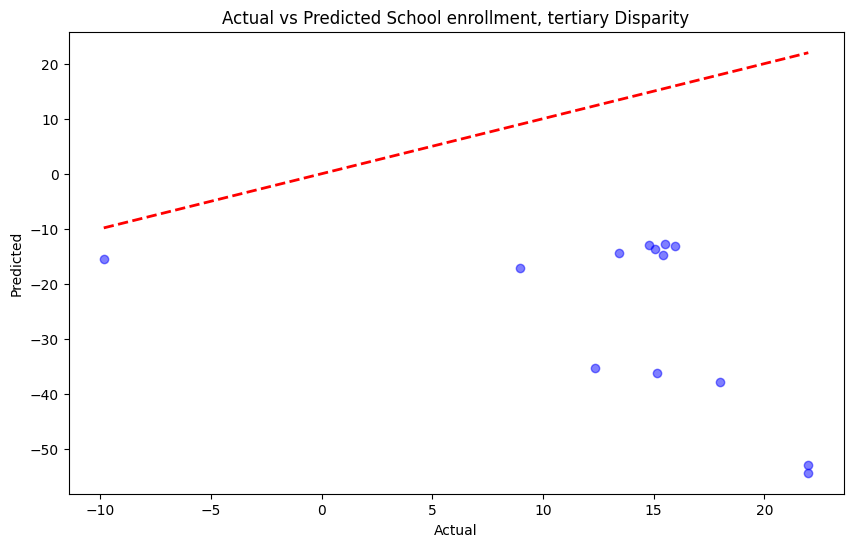

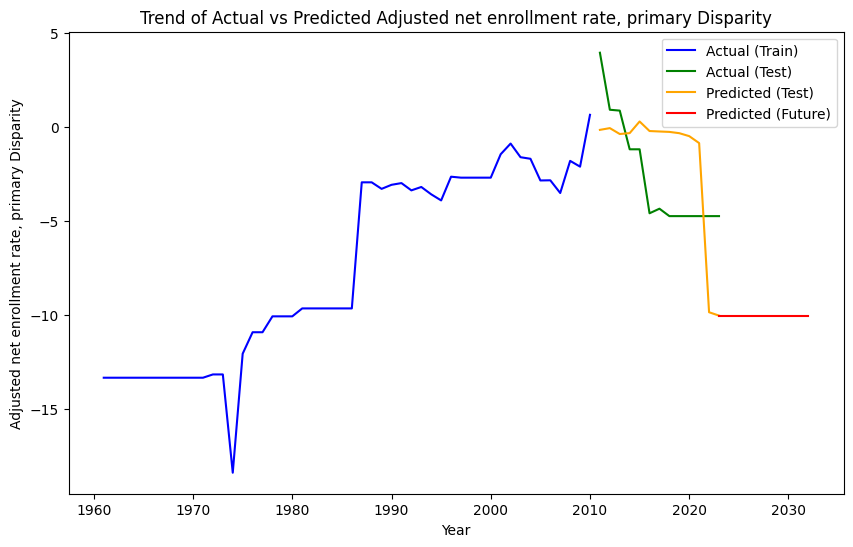

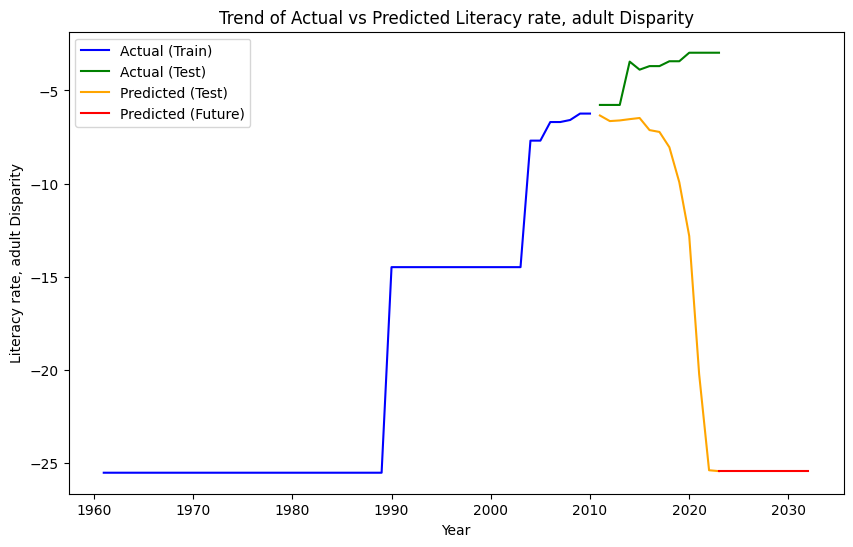

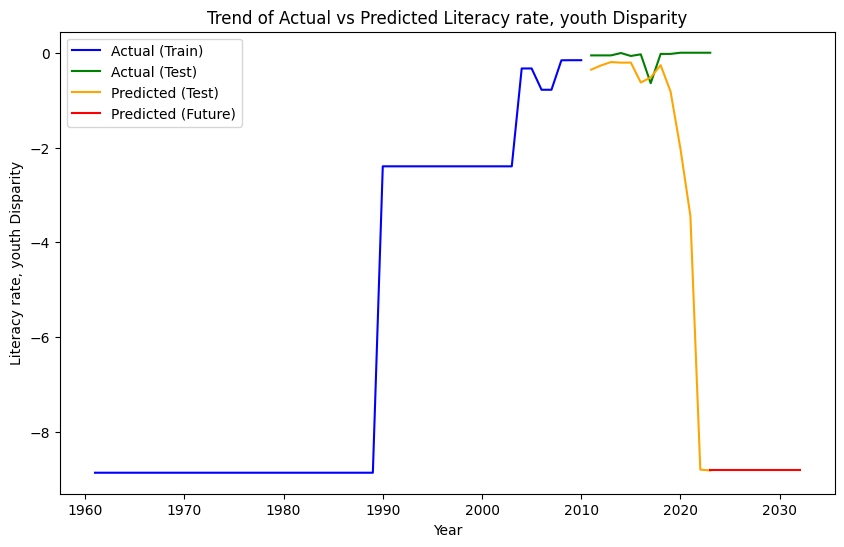

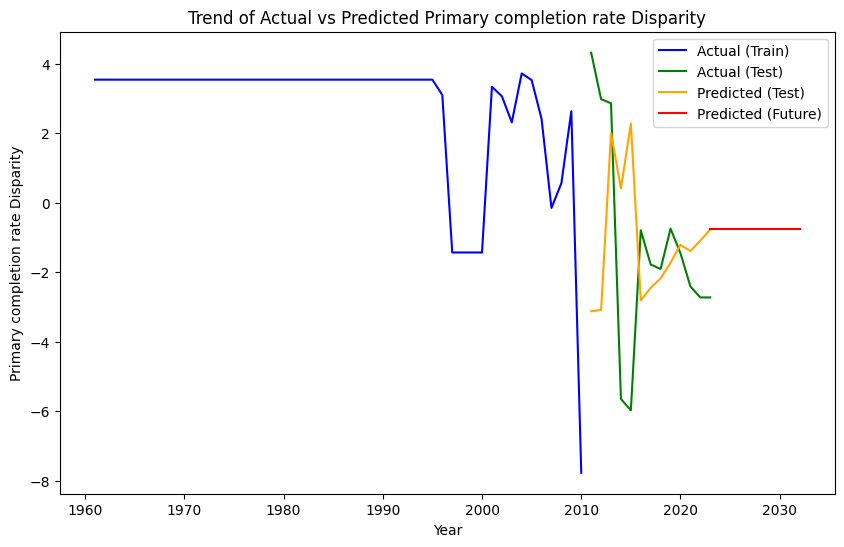

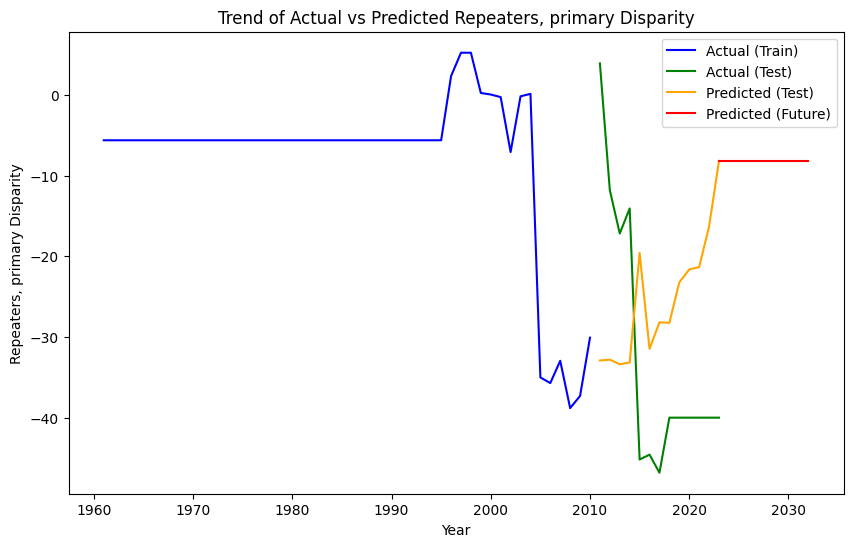

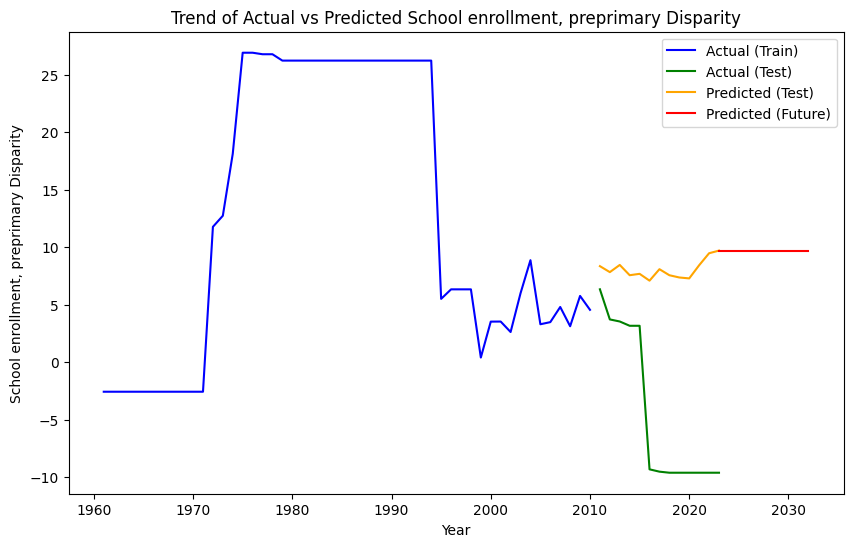

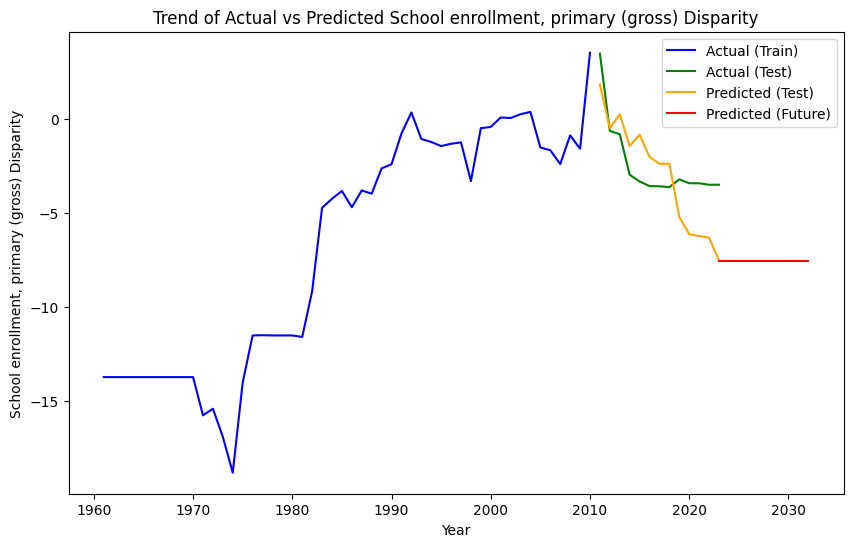

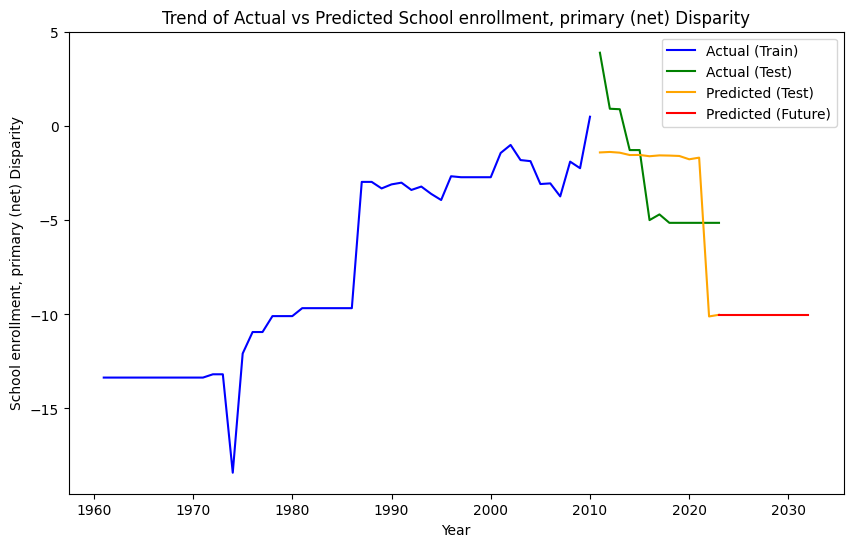

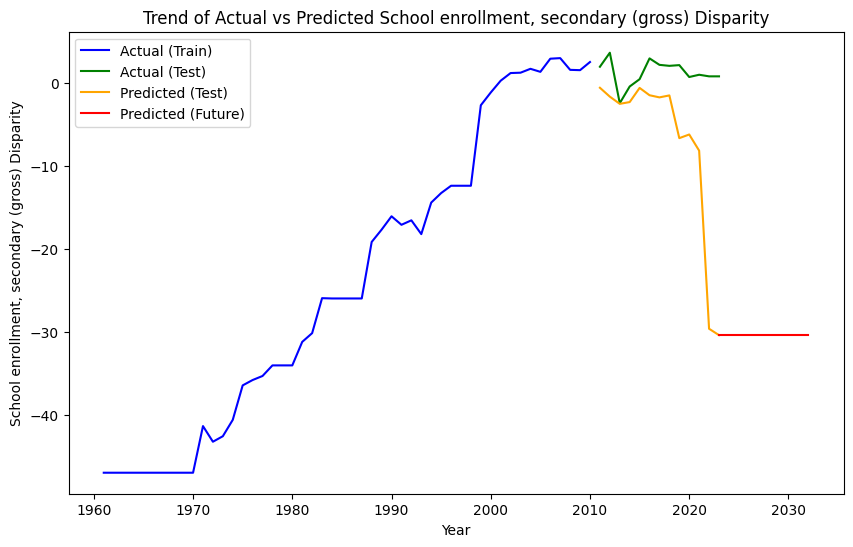

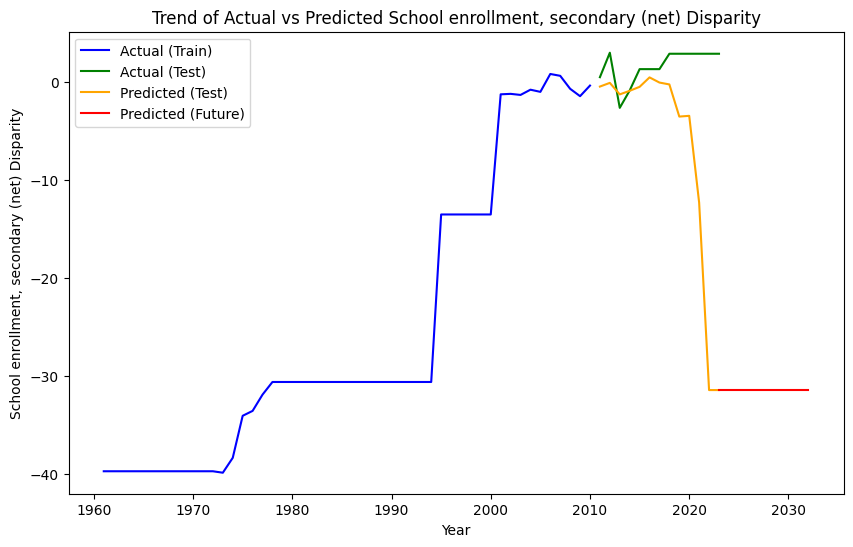

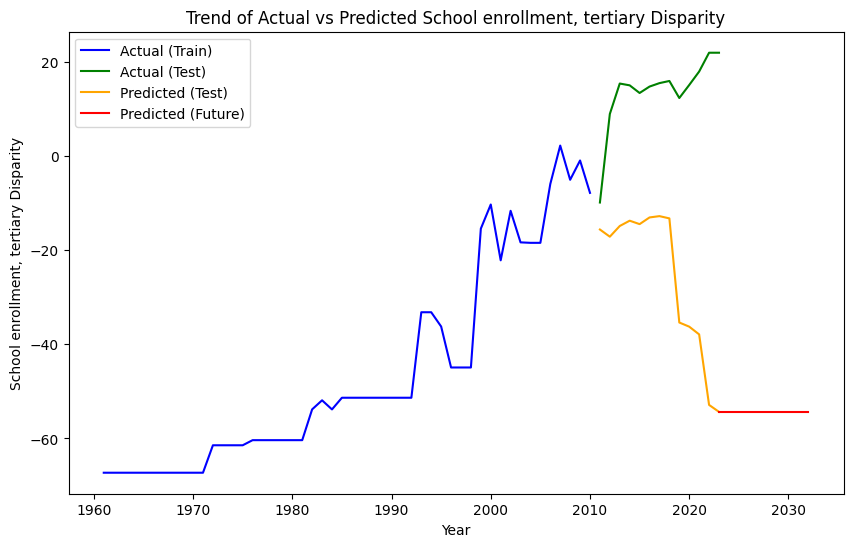

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Load the cleaned dataset with disparity index
file_path_disparity = 'Cleaned_Gender_IDN_with_Disparity.csv'
data_disparity = pd.read_csv(file_path_disparity)

# Load the original normalized dataset
file_path_original = 'Normalized_Gender_IDN.csv'
data_original = pd.read_csv(file_path_original)

# Clean column names in the original dataset
data_original.columns = data_original.columns.str.strip()

# Define features (X) based on columns in the original dataset
features = [
    'Adjusted net enrollment rate, primary, female (% of primary school age children)',
    'Adjusted net enrollment rate, primary, male (% of primary school age children)',
    'Literacy rate, adult female (% of females ages 15 and above)',
    'Literacy rate, adult male (% of males ages 15 and above)',
    'Literacy rate, youth female (% of females ages 15-24)',
    'Literacy rate, youth male (% of males ages 15-24)',
    'Primary completion rate, female (% of relevant age group)',
    'Primary completion rate, male (% of relevant age group)',
    'Repeaters, primary, female (% of female enrollment)',
    'Repeaters, primary, male (% of male enrollment)',
    'School enrollment, preprimary, female (% gross)',
    'School enrollment, preprimary, male (% gross)',
    'School enrollment, primary, female (% gross)',
    'School enrollment, primary, female (% net)',
    'School enrollment, primary, male (% gross)',
    'School enrollment, primary, male (% net)',
    'School enrollment, secondary, female (% gross)',
    'School enrollment, secondary, female (% net)',
    'School enrollment, secondary, male (% gross)',
    'School enrollment, secondary, male (% net)',
    'School enrollment, tertiary, female (% gross)',
    'School enrollment, tertiary, male (% gross)'
]

# Define targets (disparity indices) based on columns in the disparity dataset
targets = [
    'Adjusted net enrollment rate, primary Disparity',
    'Literacy rate, adult Disparity',
    'Literacy rate, youth Disparity',
    'Primary completion rate Disparity',
    'Repeaters, primary Disparity',
    'School enrollment, preprimary Disparity',
    'School enrollment, primary (gross) Disparity',
    'School enrollment, primary (net) Disparity',
    'School enrollment, secondary (gross) Disparity',
    'School enrollment, secondary (net) Disparity',
    'School enrollment, tertiary Disparity'
]

# Impute missing values in the original dataset
imputer = SimpleImputer(strategy='mean')
data_original_imputed = pd.DataFrame(imputer.fit_transform(data_original), columns=data_original.columns)

# Verify that all features are present in the dataset
missing_features = [feature for feature in features if feature not in data_original_imputed.columns]
if missing_features:
    print(f"Missing features in the dataset: {missing_features}")
else:
    print("All features are present.")

# Feature Engineering: Add year-over-year changes as features
for feature in features:
    data_original_imputed[f'{feature} YoY Change'] = data_original_imputed[feature].pct_change()

# Drop the first row because of NaN values in YoY change features
data_original_imputed = data_original_imputed.dropna().reset_index(drop=True)

# Synchronize the index of the disparity dataset with the original dataset
data_disparity = data_disparity[data_disparity['Year'].isin(data_original_imputed['Year'])].reset_index(drop=True)

# Split the data into training (1960-2010) and testing sets (2011-2022)
train_data = data_original_imputed[data_original_imputed['Year'] <= 2010]
test_data = data_original_imputed[data_original_imputed['Year'] > 2010]

# Corresponding disparity indices
train_disparity = data_disparity[data_disparity['Year'] <= 2010]
test_disparity = data_disparity[data_disparity['Year'] > 2010]

# Create a Gradient Boosting model for each target (disparity index)
models = {}
predictions = {}

# Hyperparameter tuning for Gradient Boosting
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

for target in targets:
    # Prepare features and target
    X_train = train_data.drop(columns=['Year'])
    y_train = train_disparity[target]
    X_test = test_data.drop(columns=['Year'])
    y_test = test_disparity[target]

    # Hyperparameter tuning
    gb_model = GradientBoostingRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    models[target] = best_model

    # Make predictions on the test set
    y_pred = best_model.predict(X_test)
    predictions[target] = y_pred

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Model for {target}:')
    print(f'  Mean Squared Error: {mse}')
    print(f'  R-squared: {r2}')
    print()

    # Plot the actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted {target}')
    plt.show()

# Predicting future disparities using rolling window approach

# Generate future years
future_years = np.arange(2023, 2033)

# Make predictions for future years
future_predictions = {}
for target in targets:
    model = models[target]
    current_year = test_data['Year'].max()
    X_future = test_data.drop(columns=['Year']).iloc[-1].copy().to_frame().T
    future_pred = []
    
    for year in future_years:
        # Predict the disparity for the next year
        pred = model.predict(X_future)[0]
        future_pred.append(pred)
        
        # Update the features for the next prediction (use a simplistic approach here)
        for feature in X_future.columns:
            X_future[feature] = X_future[feature].values[0]  # Use the last known value for simplicity
    
    future_predictions[target] = future_pred

# Visualize the trend of predicted vs actual disparity index over time
for target in targets:
    plt.figure(figsize=(10, 6))
    plt.plot(train_disparity['Year'], train_disparity[target], label='Actual (Train)', color='blue')
    plt.plot(test_disparity['Year'], test_disparity[target], label='Actual (Test)', color='green')
    plt.plot(test_disparity['Year'], predictions[target], label='Predicted (Test)', color='orange')
    plt.plot(future_years, future_predictions[target], label='Predicted (Future)', color='red')
    plt.xlabel('Year')
    plt.ylabel(target)
    plt.title(f'Trend of Actual vs Predicted {target}')
    plt.legend()
    plt.show()